In [1]:
### machine learning techniques used for text analysis: Word2Vec . 
##goal is to show you how you could approach a problem in general and how to do hyperparameter training."""""""
        
        
##Feature inspection---Exploratory Data Analysis
###Feature creation:----WordVec
###Model ---Logistic regression,Random forest, Naive bayes
###Model selection---a grid search has beev be applied for hyperparameter training


# more common imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re
import copy

# languange processing imports
import nltk
from gensim.corpora import Dictionary
# preprocessing imports
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve, log_loss
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline

import xgboost as xgb

# model imports
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.word2vec import Word2Vec
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
# hyperparameter training imports
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score,log_loss,roc_auc_score,roc_curve, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
# visualization imports
from IPython.display import display
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import base64
import io
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
sns.set()  # defines 

In [2]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [3]:
###Change Working Directory###

import os
os.getcwd()
#os.chdir('C:/Personal/python work/Sentiment Analysis/project ML/project ML/data_reviews')  

'/kaggle/working'

In [4]:
%ls ../input/project/project/project/data_reviews/

submission.csv  x_train.csv  yproba1_test.txt     yproba1_test_part1.txt
x_test.csv      y_train.csv  yproba1_test_df.txt


In [5]:
#Read Data Sets####

x_test = pd.read_csv('../input/project/project/project/data_reviews/x_test.csv')
x_train = pd.read_csv('../input/project/project/project/data_reviews/x_train.csv')
y_train = pd.read_csv('../input/project/project/project/data_reviews/y_train.csv')
y = y_train['is_positive_sentiment']

In [6]:
####Inspect Text Varible in data set#########

document_lengths = np.array(list(map(len, x_train.text.str.split(' '))))

print("The average number of words in a document is: {}.".format(np.mean(document_lengths)))
print("The minimum number of words in a document is: {}.".format(min(document_lengths)))
print("The maximum number of words in a document is: {}.".format(max(document_lengths)))

The average number of words in a document is: 12.524166666666666.
The minimum number of words in a document is: 1.
The maximum number of words in a document is: 63.


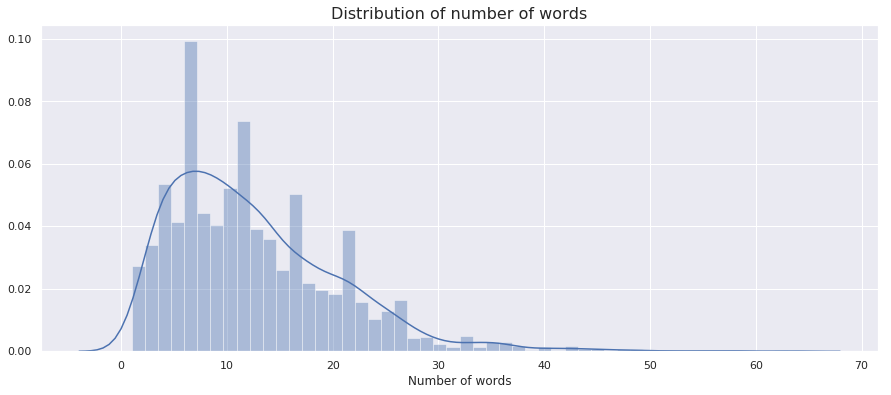

In [7]:
#######distribution of the number of words in a document.####

ig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(document_lengths, bins=50, ax=ax)

In [8]:
print("There are {} documents with over 40 words.".format(sum(document_lengths > 40)))

shorter_documents = document_lengths[document_lengths <= 40]

There are 18 documents with over 40 words.


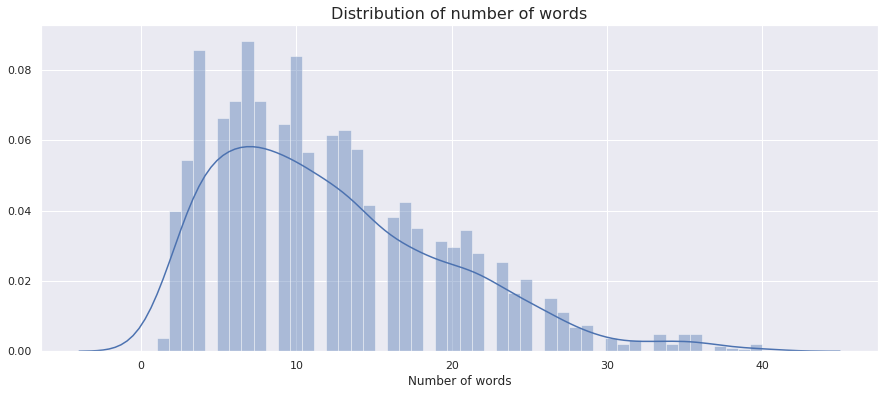

In [9]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Distribution of number of words", fontsize=16)
ax.set_xlabel("Number of words")
sns.distplot(shorter_documents, bins=50, ax=ax);

In [10]:
print("There are {} documents with tops 10 words.".format(sum(document_lengths <= 5)))

There are 464 documents with tops 10 words.


In [11]:
# find and remove non-ascii words
# I stored our special word in a variable for later use
our_special_word = 'qwerty'

def remove_ascii_words(df):
    """ removes non-ascii characters from the 'texts' column in df.
    It returns the words containig non-ascii characers.
    """
    non_ascii_words = []
    for i in range(len(df)):
        for word in df.loc[i, 'text'].split(' '):
            if any([ord(character) >= 128 for character in word]):
                non_ascii_words.append(word)
                df.loc[i, 'text'] = df.loc[i, 'text'].replace(word, our_special_word)
    return non_ascii_words

non_ascii_words_train = remove_ascii_words(x_train)
non_ascii_words_test = remove_ascii_words(x_test)

print("Replaced {} words with characters with an ordinal >= 128 in the train data.".format(
    len(non_ascii_words_train)))

Replaced 13 words with characters with an ordinal >= 128 in the train data.


In [12]:
non_ascii_words_train,non_ascii_words_test

(['is\x85was',
  'problems\x97the',
  'Québec.',
  'clichés',
  '\x96',
  'clichés',
  '\x96',
  'clichés',
  'seeing\x85',
  'Aurvåg',
  '\x96',
  '\x96',
  'fiancé'],
 ['\x96', 'puréed.', 'Café', 'crêpe'])

In [13]:
###Remove the Punctuations and numbers 
def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation

In [14]:
x_train.head(10)

,website_name,text
0,amazon,Oh and I forgot to also mention the weird colo...
1,amazon,THAT one didn't work either.
2,amazon,Waste of 13 bucks.
3,amazon,"Product is useless, since it does not have eno..."
4,amazon,None of the three sizes they sent with the hea...
5,amazon,Worst customer service.
6,amazon,The Ngage is still lacking in earbuds.
7,amazon,It always cuts out and makes a beep beep beep ...
8,amazon,the only VERY DISAPPOINTING thing was there wa...
9,amazon,Very disappointed in AccessoryOne.


In [15]:
# Here we get transform the documents into sentences for the word2vecmodel
# we made a function such that later on when we make the submission, we don't need to write duplicate code
def w2v_preprocessing(df):
    """ All the preprocessing steps for word2vec are done in this function.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df['text'] = df.text.str.lower()
    df['document_sentences'] = df.text.str.split('.')  # split texts into individual sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(nltk.word_tokenize, sentences)),
                                         df.document_sentences))  # tokenize sentences
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(map(get_good_tokens, sentences)),
                                         df.tokenized_sentences))  # remove unwanted characters
    df['tokenized_sentences'] = list(map(lambda sentences:
                                         list(filter(lambda lst: lst, sentences)),
                                         df.tokenized_sentences))  # remove empty lists

w2v_preprocessing(x_train)
w2v_preprocessing(x_test)

In [16]:
def lda_get_good_tokens(df):
    df['text'] = df.text.str.lower()
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.text))
    df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))

lda_get_good_tokens(x_train)
lda_get_good_tokens(x_test)

In [17]:
x_test.head()

,website_name,text,document_sentences,tokenized_sentences,tokenized_text
0,amazon,it only recognizes the phone as its storage de...,[it only recognizes the phone as its storage d...,"[[it, only, recognizes, the, phone, as, its, s...","[it, only, recognizes, the, phone, as, its, st..."
1,amazon,disappointing accessory from a good manufacturer.,[disappointing accessory from a good manufactu...,"[[disappointing, accessory, from, a, good, man...","[disappointing, accessory, from, a, good, manu..."
2,amazon,the one big drawback of the mp3 player is that...,[the one big drawback of the mp3 player is tha...,"[[the, one, big, drawback, of, the, mp3, playe...","[the, one, big, drawback, of, the, mp3, player..."
3,amazon,this particular model would not work with my m...,[this particular model would not work with my ...,"[[this, particular, model, would, not, work, w...","[this, particular, model, would, not, work, wi..."
4,amazon,if the two were seperated by a mere 5+ ft i st...,[if the two were seperated by a mere 5+ ft i s...,"[[if, the, two, were, seperated, by, a, mere, ...","[if, the, two, were, seperated, by, a, mere, 5..."


In [18]:
tokenized_only_dict_train = Counter(np.concatenate(x_train.tokenized_text.values))
tokenized_only_dict_test = Counter(np.concatenate(x_test.tokenized_text.values))

tokenized_only_df_train = pd.DataFrame.from_dict(tokenized_only_dict_train, orient='index')
tokenized_only_df_test = pd.DataFrame.from_dict(tokenized_only_dict_test, orient='index')
tokenized_only_df_train.rename(columns={0: 'count'}, inplace=True)
tokenized_only_df_test.rename(columns={0: 'count'}, inplace=True)

In [19]:
tokenized_only_df_train.sort_values('count', ascending=False, inplace=True)
tokenized_only_df_test.sort_values('count', ascending=False, inplace=True)

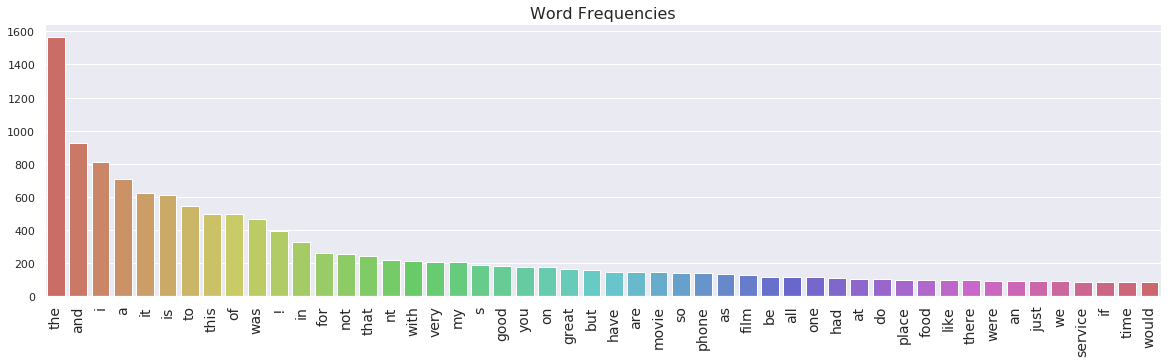

In [20]:
# I made a function out of this since I will use it again later on 
def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    
ax = word_frequency_barplot(tokenized_only_df_train)
ax.set_title("Word Frequencies", fontsize=16);


In [21]:
#################Remove words that mean little###########################33

def remove_stopwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package. In addition, we include our
    made up word in here.
    """
    # Luckily nltk already has a set of stopwords that we can remove from the texts.
    stopwords = nltk.corpus.stopwords.words('english')
    # we'll add our own special word in here 'qwerty'
    stopwords.append(our_special_word)

    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))

remove_stopwords(x_train)
remove_stopwords(x_test)

In [22]:
##############Stemming#####################
def stem_words(df):
    lemm = nltk.stem.WordNetLemmatizer()
    df['lemmatized_text'] = list(map(lambda sentence:
                                     list(map(lemm.lemmatize, sentence)),
                                     df.stopwords_removed))

    p_stemmer = nltk.stem.porter.PorterStemmer()
    df['stemmed_text'] = list(map(lambda sentence:
                                  list(map(p_stemmer.stem, sentence)),
                                  df.lemmatized_text))

stem_words(x_train)
stem_words(x_test)

In [23]:
#######Vectorize words####################3333
dictionary = Dictionary(documents=x_train.stemmed_text.values)

print("Found {} words.".format(len(dictionary.values())))

Found 3574 words.


In [24]:
dictionary.filter_extremes(no_above=0.8, no_below=3)

dictionary.compactify()  # Reindexes the remaining words after filtering
print("Left with {} words.".format(len(dictionary.values())))

Left with 1042 words.


In [25]:
#Make a BOW for every document
def document_to_bow(df):
    df['bow'] = list(map(lambda doc: dictionary.doc2bow(doc), df.stemmed_text))
    
document_to_bow(x_train)
document_to_bow(x_test)

In [26]:
#####Visualize the cleansed words frequencies

cleansed_words_df = pd.DataFrame.from_dict(dictionary.token2id, orient='index')
cleansed_words_df.rename(columns={0: 'id'}, inplace=True)

cleansed_words_df['count'] = list(map(lambda id_: dictionary.dfs.get(id_), cleansed_words_df.id))
del cleansed_words_df['id']

In [27]:
cleansed_words_df.sort_values('count', ascending=False, inplace=True)


Text(0.5, 1.0, 'Document Frequencies (Number of documents a word appears in)')

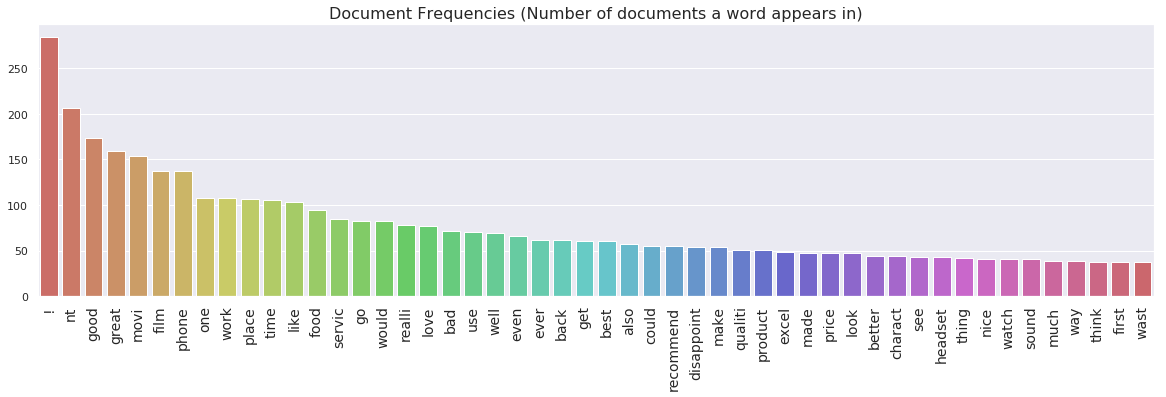

In [28]:
ax = word_frequency_barplot(cleansed_words_df)
ax.set_title("Document Frequencies (Number of documents a word appears in)", fontsize=16)

In [29]:
##############Word2Vec training###############
sentences = []
for sentence_group in x_train.tokenized_sentences:
    sentences.extend(sentence_group)

print("Number of sentences: {}.".format(len(sentences)))
print("Number of texts: {}.".format(len(x_train)))
print("Number of texts: {}.".format(len(x_test)))




Number of sentences: 2531.
Number of texts: 2400.
Number of texts: 600.


In [30]:
%%time
# Set values for various parameters
num_features = 700    # Word vector dimensionality
min_word_count = 10    # Minimum word count
num_workers = 10      # Number of threads to run in parallel
context = 10          # Context window size
downsampling = 0.01   # Downsample setting for frequent words

# Initialize and train the model
W2Vmodel = Word2Vec(sentences=sentences,
                    sg=1,
                    hs=0,
                    workers=num_workers,
                    size=num_features,
                    min_count=min_word_count,
                    window=context,
                    sample=downsampling,
                    negative=5,
                    iter=6)

CPU times: user 3.61 s, sys: 24 ms, total: 3.64 s
Wall time: 1.35 s


In [31]:
#####3Word2Vec feature inspection


def get_w2v_features(w2v_model, sentence_group):
    """ Transform a sentence_group (containing multiple lists
    of words) into a feature vector. It averages out all the
    word vectors of the sentence_group.
    """
    words = np.concatenate(sentence_group)  # words in text
    index2word_set = set(w2v_model.wv.vocab.keys())  # words known to model
    
    featureVec = np.zeros(w2v_model.vector_size, dtype="float32")
    
    # Initialize a counter for number of words in a review
    nwords = 0
    # Loop over each word in the comment and, if it is in the model's vocabulary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            featureVec = np.add(featureVec, w2v_model[word])
            nwords += 1.

    # Divide the result by the number of words to get the average
    if nwords > 0:
        featureVec = np.divide(featureVec, nwords)
    return featureVec

x_train['w2v_features'] = list(map(lambda sen_group:
                                      get_w2v_features(W2Vmodel, sen_group),
                                      x_train.tokenized_sentences))
x_test['w2v_features'] = list(map(lambda sen_group:
                                      get_w2v_features(W2Vmodel, sen_group),
                                      x_test.tokenized_sentences))

In [32]:
#######Classification and hyperparameter tuning#########

In [33]:
X_train_w2v = np.array(list(map(np.array, x_train.w2v_features)))
X_test_w2v = np.array(list(map(np.array, x_test.w2v_features)))


In [34]:
y_train.head()

,is_positive_sentiment
0,0
1,0
2,0
3,0
4,0


In [35]:
y = y_train['is_positive_sentiment']
xtrain, xvalid, ytrain, yvalid = train_test_split(X_train_w2v, y
                                                  , stratify=y
                                                  ,random_state=42, 
                                                  test_size=0.1, shuffle=True)
X_train_w2v.shape,X_test_w2v.shape,y.shape, xtrain.shape, xvalid.shape, ytrain.shape, yvalid.shape

((2400, 700), (600, 700), (2400,), (2160, 700), (240, 700), (2160,), (240,))

In [36]:
grids = {}
accuracies = {}

In [37]:
# Fitting a simple Logistic Regression on TFIDF#########
def grid_search_best_params(model_name, pipeline, params, xtrain, ytrain, xvalid, yvalid, X, Y):
    grid = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1,refit='accuracy',scoring=['accuracy','neg_log_loss','roc_auc'])
    grid.fit(X, Y)
    predictions = grid.predict_proba(xvalid)
    grids[model_name] = copy.deepcopy(grid)
    #print ("logloss: %0.3f " % multiclass_logloss(yvalid, predictions))
    y_pred_test = grid.predict(xvalid)
    y_test_proba = grid.predict_proba(xvalid)
    print("Log Loss for %s on Test with W2V: %s"%(model_name,log_loss(yvalid, y_pred_test)))
    print("ROC AUC for %s on Test with W2V: %s"%(model_name,roc_auc_score(yvalid, y_test_proba.T[1])))
    print("Accuracy for %s on Test with W2V: %s"%(model_name,accuracy_score(yvalid, y_pred_test)))
    y_pred_train=grid.predict(xtrain)
    y_train_proba = grid.predict_proba(xtrain)
    print("Log Loss for %s on Training with W2V: %s"%(model_name,log_loss(ytrain, y_pred_train)))
    print("ROC AUC for %s on Training with W2V: %s"%(model_name,roc_auc_score(ytrain, y_train_proba.T[1])))
    print("Accuracy for %s on Training with W2V: %s"%(model_name, accuracy_score(ytrain,y_pred_train)))
    print('Best Score : %.2f'%(grid.best_score_*100))
    print('Best Paramerter Settings : ',grid.best_params_)
    #print("ROC Area Under Curve in % : ",cross_val_score(pipeline_lr, X, Y, scoring="roc_auc", cv=5)*100)
    conf_mat = confusion_matrix(yvalid, y_pred_test)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(conf_mat, annot=True, fmt='d')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    accuracies = {'Train Accuracy':accuracy_score(ytrain,y_pred_train), 
                  'Test Accuracy':accuracy_score(yvalid, y_pred_test),
                  'Best Accuracy': grid.best_score_,
                  'Train Log Loss':log_loss(ytrain, y_pred_train), 
                  'Test Log Loss':log_loss(yvalid, y_pred_test),
                  'Train ROC AUC': roc_auc_score(ytrain, y_train_proba.T[1]), 
                  'Test ROC AUC': roc_auc_score(yvalid, y_test_proba.T[1]),
                  'Best Param Settings' :grid.best_params_}
    return accuracies

Log Loss for LogisticRegression_W2V on Test with W2V: 8.490859158502603
ROC AUC for LogisticRegression_W2V on Test with W2V: 0.8134027777777778
Accuracy for LogisticRegression_W2V on Test with W2V: 0.7541666666666667
Log Loss for LogisticRegression_W2V on Training with W2V: 9.050536728165948
ROC AUC for LogisticRegression_W2V on Training with W2V: 0.8181678669410151
Accuracy for LogisticRegression_W2V on Training with W2V: 0.7379629629629629
Best Score : 68.71
Best Paramerter Settings :  {'logisticregression__C': 100, 'logisticregression__penalty': 'l1'}


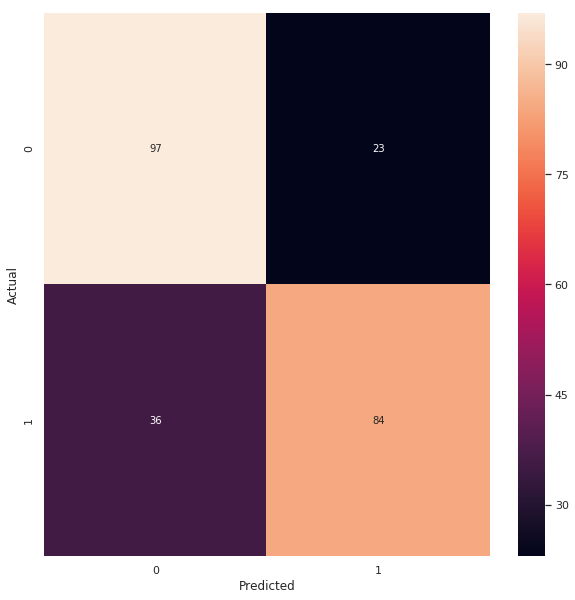

In [38]:
params_lr = {'logisticregression__C': [0.01, 0.1, 0.5,1, 10, 100],
             'logisticregression__penalty': ['l1','l2'],
          }
lr = make_pipeline(LogisticRegression())

accuracies['LogisticRegression(W2V)'] = grid_search_best_params('LogisticRegression_W2V', lr, params_lr,xtrain,ytrain,xvalid,yvalid,X_train_w2v,y)

In [39]:
params_svc = {#'svc__kernel': ['rbf','poly','sigmoid'],
                'svc__C': [0.01, 0.1, 0.5, 1, 10, 100, 10/X_train_w2v.shape[1]],
                'svc__gamma' : [1/X_train_w2v.shape[1],'auto','scale'],
                }
svc = make_pipeline(SVC(probability=True))

##accuracies['SVC(Embedding)'] = grid_search_best_params('SVC',svc, params_svc,xtrain_glove,y_train_sentence,xvalid_glove,y_test_sentence,x_train_all,y_train_all)

In [40]:
params_nb = {
            'multinomialnb__alpha': [0.1, .5, 1.0 , 10],
            }
nb = make_pipeline(MultinomialNB())

#accuracies['NaiveBayes(W2V)'] = grid_search_best_params('NaiveBayes_W2V',nb, params_nb,xtrain,ytrain,xvalid,yvalid,X_train_w2v,y)

Log Loss for RandomForest_W2V on Test with W2V: 8.634767395158773
ROC AUC for RandomForest_W2V on Test with W2V: 0.8156944444444445
Accuracy for RandomForest_W2V on Test with W2V: 0.75
Log Loss for RandomForest_W2V on Training with W2V: 10.121876182274482
ROC AUC for RandomForest_W2V on Training with W2V: 0.7794410150891632
Accuracy for RandomForest_W2V on Training with W2V: 0.7069444444444445
Best Score : 63.83
Best Paramerter Settings :  {'randomforestclassifier__bootstrap': False, 'randomforestclassifier__max_depth': 4, 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__n_estimators': 52}


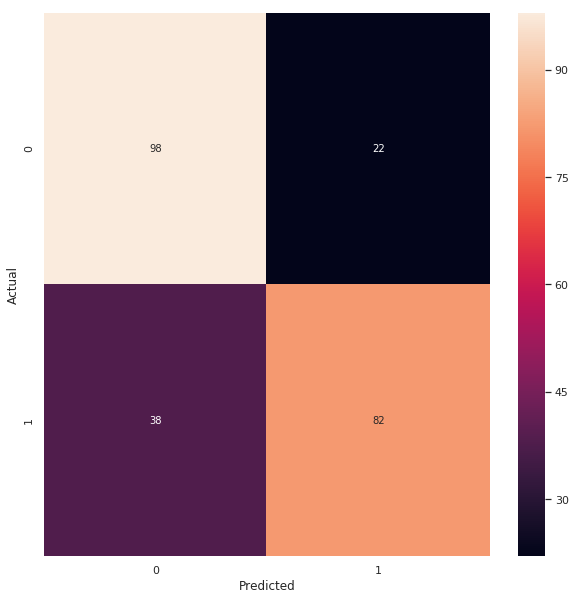

In [41]:
sqrt_features = int(np.sqrt(X_train_w2v.shape[1]))
params_rf = {'randomforestclassifier__n_estimators': [sqrt_features//2,sqrt_features,sqrt_features*2,sqrt_features*4,100, 200,500],
             'randomforestclassifier__max_depth':[None,3,4,5],
             'randomforestclassifier__min_samples_leaf': [0.1,0.2,0.3,0.4,0.5, 1],
             'randomforestclassifier__bootstrap' : [True, False],
            }
rf = make_pipeline(RandomForestClassifier())

accuracies['RandomForest(W2V)'] = grid_search_best_params('RandomForest_W2V',rf, params_rf,xtrain,ytrain,xvalid,yvalid,X_train_w2v,y)

Log Loss for ExtremeGradientBoosting_W2V on Test with W2V: 1.8708737096493768
ROC AUC for ExtremeGradientBoosting_W2V on Test with W2V: 0.9923611111111111
Accuracy for ExtremeGradientBoosting_W2V on Test with W2V: 0.9458333333333333
Log Loss for ExtremeGradientBoosting_W2V on Training with W2V: 1.439133081769066
ROC AUC for ExtremeGradientBoosting_W2V on Training with W2V: 0.9925274348422497
Accuracy for ExtremeGradientBoosting_W2V on Training with W2V: 0.9583333333333334
Best Score : 63.46
Best Paramerter Settings :  {'xgbclassifier__learning_rate': 0.3, 'xgbclassifier__max_depth': 2, 'xgbclassifier__n_estimators': 200}


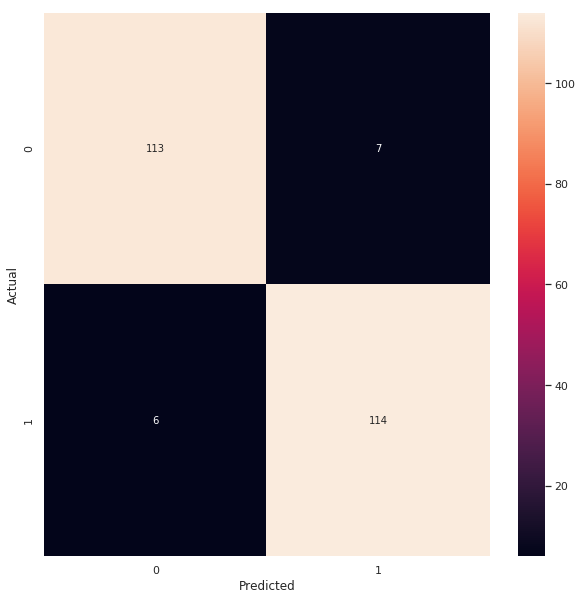

In [42]:
sqrt_features = int(np.sqrt(X_train_w2v.shape[1]))
params_xgb = {'xgbclassifier__n_estimators': [sqrt_features,sqrt_features*2, 100, 200 ],
                'xgbclassifier__learning_rate': [0.001,0.01,0.1,0.3],
                'xgbclassifier__max_depth' : [2, 3, 4, 5,],
                }
pipeline_xgb = make_pipeline(xgb.XGBClassifier())

accuracies['ExtremeGradientBoosting(W2V)'] = grid_search_best_params('ExtremeGradientBoosting_W2V',pipeline_xgb, params_xgb,xtrain,ytrain,xvalid,yvalid,X_train_w2v,y)

In [43]:
## We'll now use best parameters we found out above from grid search and plot model accuracy.
df = pd.DataFrame(accuracies)
df = df.transpose()
df = df.reset_index()
df = df.rename(columns={'index':'model_name'})
df

,model_name,Best Accuracy,Best Param Settings,Test Accuracy,Test Log Loss,Test ROC AUC,Train Accuracy,Train Log Loss,Train ROC AUC
0,LogisticRegression(W2V),0.687083,"{'logisticregression__C': 100, 'logisticregres...",0.754167,8.49086,0.813403,0.737963,9.05054,0.818168
1,RandomForest(W2V),0.638333,"{'randomforestclassifier__bootstrap': False, '...",0.75,8.63477,0.815694,0.706944,10.1219,0.779441
2,ExtremeGradientBoosting(W2V),0.634583,"{'xgbclassifier__learning_rate': 0.3, 'xgbclas...",0.945833,1.87087,0.992361,0.958333,1.43913,0.992527


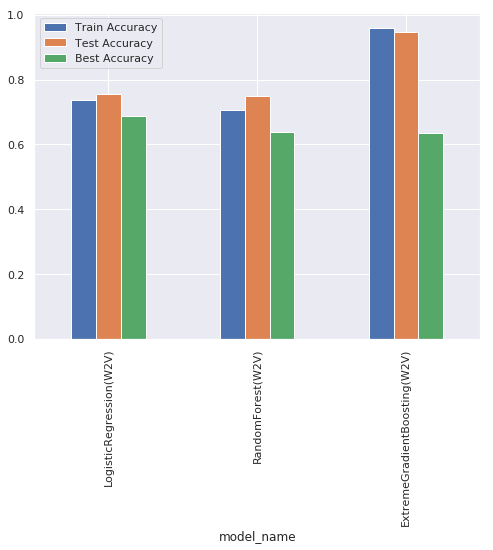

In [44]:
df.plot(x='model_name',y=['Train Accuracy', 'Test Accuracy','Best Accuracy'], kind='bar', figsize=(8,6))

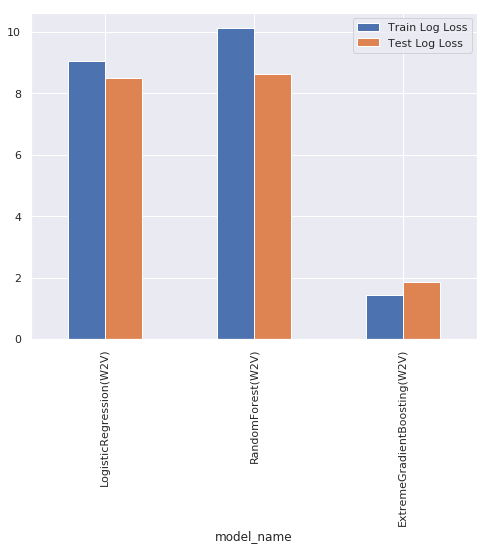

In [45]:
df.plot(x='model_name',y=['Train Log Loss', 'Test Log Loss'], kind='bar', figsize=(8,6))

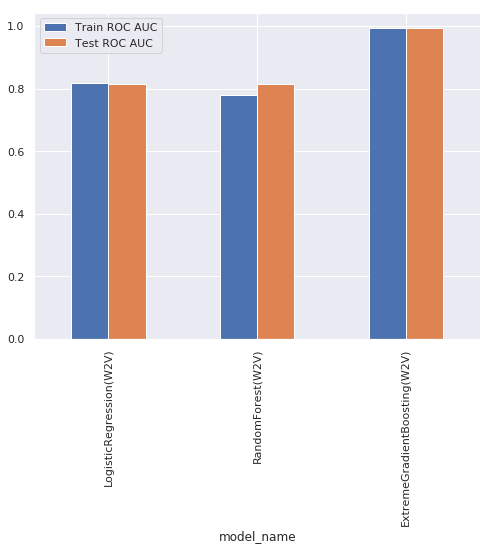

In [46]:
df.plot(x='model_name',y=['Train ROC AUC', 'Test ROC AUC'], kind='bar', figsize=(8,6))

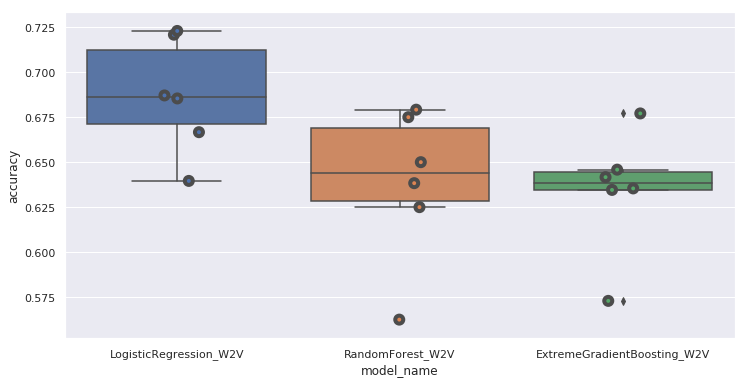

In [47]:
## We'll now use best parameters we found out above from grid search and plot model accuracy.
plt.figure(figsize=(12,6))
CV=5
cv_df = pd.DataFrame(index=range(CV * len(grids)))
entries = []
for model_name, model in grids.items():
    #model_name = model.__class__.__name__
    accuracies = df_lr = pd.DataFrame(model.cv_results_)
    df_lr = df_lr[df_lr.params == model.best_params_]
    #print(df_lr.columns)
    accuracies = df_lr[['split0_test_accuracy','split1_test_accuracy','split2_test_accuracy','split3_test_accuracy','split4_test_accuracy','mean_test_accuracy']].values[0]
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=4)
plt.show()

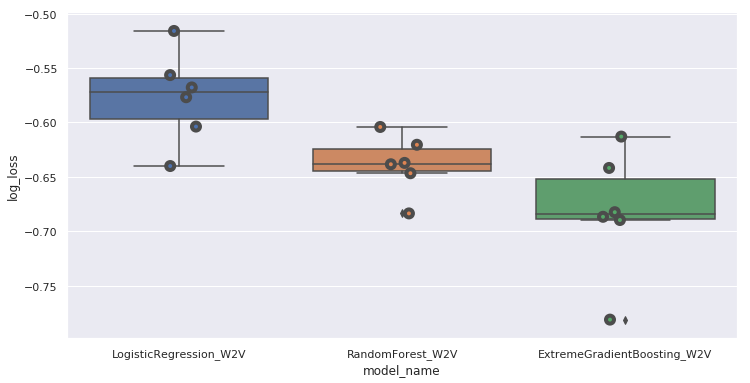

In [48]:
## We'll now use best parameters we found out above from grid search and plot model accuracy.
plt.figure(figsize=(12,6))
cv_df = pd.DataFrame(index=range(CV * len(grids)))
entries = []
for model_name, model in grids.items():
    #model_name = model.__class__.__name__
    df_lr = pd.DataFrame(model.cv_results_)
    df_lr = df_lr[df_lr.params == model.best_params_]
    #print(df_lr.columns)
    losses = df_lr[['split0_test_neg_log_loss','split1_test_neg_log_loss','split2_test_neg_log_loss','split3_test_neg_log_loss','split4_test_neg_log_loss','mean_test_neg_log_loss']].values[0]
    for fold_idx, loss in enumerate(losses):
        entries.append((model_name, fold_idx, loss))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'log_loss'])

sns.boxplot(x='model_name', y='log_loss', data=cv_df)
sns.stripplot(x='model_name', y='log_loss', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=4)
plt.show()

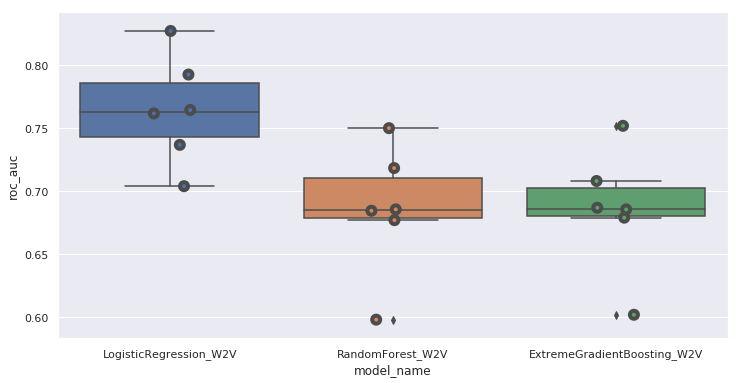

In [49]:
## We'll now use best parameters we found out above from grid search and plot model accuracy.
plt.figure(figsize=(12,6))
cv_df = pd.DataFrame(index=range(CV * len(grids)))
entries = []
for model_name, model in grids.items():
    #model_name = model.__class__.__name__
    df_lr = pd.DataFrame(model.cv_results_)
    df_lr = df_lr[df_lr.params == model.best_params_]
    #print(df_lr.columns)
    roc_aucs = df_lr[['split0_test_roc_auc','split1_test_roc_auc','split2_test_roc_auc','split3_test_roc_auc','split4_test_roc_auc','mean_test_roc_auc']].values[0]
    for fold_idx, roc_auc in enumerate(roc_aucs):
        entries.append((model_name, fold_idx, roc_auc))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'roc_auc'])

sns.boxplot(x='model_name', y='roc_auc', data=cv_df)
sns.stripplot(x='model_name', y='roc_auc', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=4)
plt.show()

In [50]:
for model_name, model in grids.items():
    print(model_name + ' 5 Fold Log Loss(Error)')
    df_lr = pd.DataFrame(model.cv_results_)
    df_lr = df_lr[df_lr.params == model.best_params_]
    errors = df_lr[['split0_test_neg_log_loss','split1_test_neg_log_loss','split2_test_neg_log_loss','split3_test_neg_log_loss','split4_test_neg_log_loss','mean_test_neg_log_loss']].values[0]
    print(errors)

LogisticRegression_W2V 5 Fold Log Loss(Error)
[-0.5159832  -0.56786092 -0.63999963 -0.60377603 -0.55649942 -0.57682384]
RandomForest_W2V 5 Fold Log Loss(Error)
[-0.60413615 -0.63712615 -0.68350114 -0.64660535 -0.62048231 -0.63837022]
ExtremeGradientBoosting_W2V 5 Fold Log Loss(Error)
[-0.61296648 -0.64175632 -0.7810132  -0.68956032 -0.68660736 -0.68238074]


In [51]:
for model_name, model in grids.items():
    print(model_name + '5 Fold ROC AUC')
    df_lr = pd.DataFrame(model.cv_results_)
    df_lr = df_lr[df_lr.params == model.best_params_]
    roc_aucs = df_lr[['split0_test_roc_auc','split1_test_roc_auc','split2_test_roc_auc','split3_test_roc_auc','split4_test_roc_auc','mean_test_roc_auc']].values[0]
    print(roc_aucs)

LogisticRegression_W2V5 Fold ROC AUC
[0.82699653 0.7615191  0.7037934  0.73657986 0.79238715 0.76425521]
RandomForest_W2V5 Fold ROC AUC
[0.74984375 0.68429688 0.59787326 0.67682292 0.7181684  0.68540104]
ExtremeGradientBoosting_W2V5 Fold ROC AUC
[0.75170139 0.70789062 0.60172743 0.67878472 0.68667535 0.6853559 ]


In [52]:
for model_name, model in grids.items():
    print(model_name+' 5 Fold Accuracies')
    df_lr = pd.DataFrame(model.cv_results_)
    df_lr = df_lr[df_lr.params == model.best_params_]
    accuracies = df_lr[['split0_test_accuracy','split1_test_accuracy','split2_test_accuracy','split3_test_accuracy','split4_test_accuracy','mean_test_accuracy']].values[0]
    print(accuracies)

LogisticRegression_W2V 5 Fold Accuracies
[0.72083333 0.68541667 0.63958333 0.66666667 0.72291667 0.68708333]
RandomForest_W2V 5 Fold Accuracies
[0.675      0.65       0.5625     0.625      0.67916667 0.63833333]
ExtremeGradientBoosting_W2V 5 Fold Accuracies
[0.67708333 0.64583333 0.57291667 0.63541667 0.64166667 0.63458333]


In [53]:
for model_name, grid in grids.items():
    submission_predictions = grid.predict_proba(X_test_w2v)[:,1]
    np.savetxt("yproba_part3_%s.txt"%model_name, submission_predictions,newline='\r\n')
    #print(display.HTML('<a href="yproba_part1_%s.txt" target="_blank">Y_TEST_PROBA_PART1_%s</a>'%(model_name,model_name)))